<a href="https://colab.research.google.com/github/Jonathan9219/Accidentabilidad/blob/main/Proyecto_Accidentabilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Liberar memoria manualmente
from google.colab import files
import gc
gc.collect()

# Ver memoria disponible
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.1Gi        10Gi       2.0Mi       740Mi        11Gi
Swap:             0B          0B          0B


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sqlite3 as sql
import plotly.graph_objs as go
import plotly.express as px
import sys
from mlxtend.preprocessing import TransactionEncoder
import joblib

In [14]:
# Para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [15]:
# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [16]:
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("Entorno configurado correctamente.")

class AccidentalidadML:
    """
    Clase unificada para análisis de accidentalidad vial con ML
    """

    def __init__(self):
        self.df = None
        self.target_column = None
        self.preprocessor = None
        self.best_model = None
        self.best_model_name = None

    def cargar_y_limpiar_datos(self):
        """
        Carga y limpia los datos - VERSIÓN CORREGIDA
        """
        print("CARGANDO Y LIMPIANDO DATOS DE ACCIDENTALIDAD...")

        # CORREGIDO: Usar comillas rectas y URL sin espacios
        ruta_archivo = "https://raw.githubusercontent.com/Jonathan9219/Accidentabilidad/main/AMVA_Accidentalidad_20191022_2.csv"

        try:
            # CORREGIDO: Especificar el separador correcto
            self.df = pd.read_csv(ruta_archivo, sep=';', encoding='latin-1')
            print(f"✓ Datos cargados: {self.df.shape[0]} filas, {self.df.shape[1]} columnas")
        except Exception as e:
            print(f"Error al cargar datos: {e}")
            # Intentar con encoding diferente
            try:
                self.df = pd.read_csv(ruta_archivo, sep=';', encoding='utf-8')
                print(f"✓ Datos cargados con UTF-8: {self.df.shape[0]} filas")
            except:
                print("No se pudo cargar el archivo")
                return None
                        # Mostrar información básica del dataset
        print("\n🔍 INFORMACIÓN INICIAL DEL DATASET:")
        print(f"Columnas: {list(self.df.columns)}")
        print(f"Primeras filas:")
        print(self.df.head(3))
        # Renombrar columnas problemáticas
        column_rename_map = {}
        for col in self.df.columns:
            if 'GRAVEDAD' in col.upper() or 'DAÑOS' in col.upper():
                column_rename_map[col] = 'GRAVEDAD_ACCIDENTE'
            elif 'DÍA' in col.upper() and 'SEMANA' in col.upper():
                column_rename_map[col] = 'DIA_SEMANA'

        if column_rename_map:
            self.df = self.df.rename(columns=column_rename_map)
            print(f"✓ Columnas renombradas: {column_rename_map}")

        print("\n VALORES NULOS POR COLUMNA:")
        print(self.df.isnull().sum())
        # Eliminar solo filas con muchos valores nulos
        filas_antes = len(self.df)
        self.df = self.df.dropna(thresh=len(self.df.columns) // 2)
        filas_despues = len(self.df)
        print(f"✓ Filas eliminadas por valores nulos: {filas_antes - filas_despues}")
        print(f"✓ Filas restantes: {filas_despues}")
        # Convertir FECHA si existe
        fecha_cols = [col for col in self.df.columns if 'FECHA' in col.upper()]
        if fecha_cols:
            fecha_col = fecha_cols[0]
            self.df[fecha_col] = pd.to_datetime(self.df[fecha_col], dayfirst=True, errors='coerce')
            print(f"✓ Columna {fecha_col} convertida a datetime")
            # Limpiar HORA si existe
        hora_cols = [col for col in self.df.columns if 'HORA' in col.upper()]
        if hora_cols:
            hora_col = hora_cols[0]
            self.df[hora_col] = self.df[hora_col].astype(str).str.strip()
            def limpiar_hora(hora_str):
                try:
                    # Para formato HH:MM
                    if ':' in hora_str and len(hora_str) <= 5:
                        return pd.to_datetime(hora_str, format='%H:%M').time()
                    # Para otros formatos
                    return pd.to_datetime(hora_str, errors='coerce').time()
                except:
                    return None

            self.df['HORA_LIMPIA'] = self.df[hora_col].apply(limpiar_hora)
            self.df['HORA_NUM'] = self.df['HORA_LIMPIA'].apply(lambda x: x.hour if x else None)
            print("✓ Hora limpiada y convertida")
            # Estandarizar texto en columnas categóricas
        columnas_texto = self.df.select_dtypes(include=['object']).columns
        for col in columnas_texto:
            self.df[col] = self.df[col].astype(str).str.upper().str.strip()
            # Crear variables derivadas
        self._crear_variables_derivadas()

        print("✅ CARGA Y LIMPIEZA COMPLETADA")
        return self.df

    def _crear_variables_derivadas(self):
        """Crear variables derivadas de fecha y hora"""
        print("🛠️ CREANDO VARIABLES DERIVADAS...")
         # Buscar columna de fecha
        fecha_cols = [col for col in self.df.columns if 'FECHA' in col.upper()]
        if fecha_cols:
            fecha_col = fecha_cols[0]
            self.df['MES'] = self.df[fecha_col].dt.month
            self.df['DIA_SEMANA_NUM'] = self.df[fecha_col].dt.dayofweek
            self.df['AÑO'] = self.df[fecha_col].dt.year
            print("✓ Variables de fecha creadas")
             # Crear franjas horarias
        if 'HORA_NUM' in self.df.columns:
            self.df['FRANJA_HORARIA'] = self.df['HORA_NUM'].apply(lambda x:
                'MADRUGADA (0-6)' if 0 <= x < 6 else
                'MAÑANA (6-12)' if 6 <= x < 12 else
                'TARDE (12-18)' if 12 <= x < 18 else
                'NOCHE (18-24)' if 18 <= x <= 24 else 'DESCONOCIDO'
            )
            print("✓ Franjas horarias creadas")

    def analisis_exploratorio_completo(self):
        """Análisis exploratorio completo"""
        if self.df is None:
            print("Error: No hay datos cargados.")
            return

        print("\n" + "="*60)
        print("ANÁLISIS EXPLORATORIO COMPLETO")
        print("="*60)
         # 1. Estadísticas básicas
        print("1. ESTADÍSTICAS BÁSICAS:")
        print(f"Total de registros: {len(self.df)}")
        print(f"Total de columnas: {len(self.df.columns)}")
        # 2. Distribución de variables categóricas importantes
        columnas_importantes = ['GRAVEDAD_ACCIDENTE', 'CLASE', 'COMUNA', 'DIA_SEMANA']
        for col in columnas_importantes:
            if col in self.df.columns:
                print(f"\n2. DISTRIBUCIÓN DE {col}:")
                distrib = self.df[col].value_counts().head(5)
                for valor, cantidad in distrib.items():
                    porcentaje = (cantidad / len(self.df)) * 100
                    print(f"  {valor}: {cantidad} ({porcentaje:.1f}%)")
                    # 3. Generar visualizaciones básicas
        self._generar_visualizaciones_basicas()

    def _generar_visualizaciones_basicas(self):
        """Generar visualizaciones exploratorias básicas"""
        print("\n GENERANDO VISUALIZACIONES BÁSICAS...")
        # Distribución de gravedad si existe
        if 'GRAVEDAD_ACCIDENTE' in self.df.columns:
            plt.figure(figsize=(10, 6))
            self.df['GRAVEDAD_ACCIDENTE'].value_counts().plot(kind='bar')
            plt.title('Distribución de Gravedad de Accidentes')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('distribucion_gravedad.png', dpi=300, bbox_inches='tight')
            plt.show()
            # Distribución por mes si existe
        if 'MES' in self.df.columns:
            plt.figure(figsize=(12, 6))
            self.df['MES'].value_counts().sort_index().plot(kind='bar')
            plt.title('Accidentes por Mes')
            plt.xlabel('Mes')
            plt.ylabel('Número de Accidentes')
            plt.tight_layout()
            plt.savefig('accidentes_por_mes.png', dpi=300, bbox_inches='tight')
            plt.show()

    def preparar_datos_ml(self, target_column='GRAVEDAD_ACCIDENTE'):
        """Prepara los datos para machine learning"""
        print(f"\n⚙️ PREPARANDO DATOS PARA ML (Variable objetivo: {target_column})...")

        if target_column not in self.df.columns:
            print(f"Error: La columna '{target_column}' no existe.")
            print("Columnas disponibles:", list(self.df.columns))
            return None

        self.target_column = target_column
        # Identificar características automáticamente
        all_features = [col for col in self.df.columns if col != target_column]
        # Excluir columnas problemáticas
        exclude_patterns = ['FECHA', 'HORA', 'HORA_LIMPIA', 'HORA_STR']
        features_filtradas = [col for col in all_features if not any(pat in col.upper() for pat in exclude_patterns)]
        # Auto-detectar tipos
        numeric_features = self.df[features_filtradas].select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = self.df[features_filtradas].select_dtypes(include=['object']).columns.tolist()

        print(f"Características numéricas ({len(numeric_features)}): {numeric_features}")
        print(f"Características categóricas ({len(categorical_features)}): {categorical_features}")
        # Seleccionar características
        features = numeric_features + categorical_features
        X = self.df[features]
        y = self.df[target_column]
         # Codificar variable objetivo si es categórica
        if y.dtype == 'object':
            self.label_encoder = LabelEncoder()
            y_encoded = self.label_encoder.fit_transform(y)
            print(f"Variable objetivo codificada. Clases: {list(self.label_encoder.classes_)}")
        else:
            y_encoded = y
            # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
        print(f"Conjunto de prueba: {X_test.shape[0]} muestras")
        # Crear pipeline de preprocesamiento
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        return X_train, X_test, y_train, y_test

    def entrenar_modelos(self):
        """Entrena y compara múltiples modelos"""
        if not hasattr(self, 'X_train'):
            print("Error: Datos no preparados. Ejecutar preparar_datos_ml() primero.")
            return None

        print("\n ENTRENANDO Y COMPARANDO MODELOS...")
        # Modelos simplificados para prueba rápida
        modelos = {
            'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42)
        }
        # Crear pipelines
        pipelines = {}
        for nombre, modelo in modelos.items():
            pipelines[nombre] = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('model', modelo)
            ])
            # Evaluar con validación cruzada
        resultados = {}
        print("\nVALIDACIÓN CRUZADA (3 folds para mayor velocidad):")

        for nombre, pipeline in pipelines.items():
            try:
                cv_scores = cross_val_score(pipeline, self.X_train, self.y_train, cv=3, scoring='accuracy')
                resultados[nombre] = {
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'pipeline': pipeline
                }
                print(f"{nombre}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
            except Exception as e:
                print(f"Error con {nombre}: {e}")

        if not resultados:
            print("No se pudo entrenar ningún modelo")
            return None
            # Seleccionar mejor modelo
        self.best_model_name = max(resultados, key=lambda x: resultados[x]['cv_mean'])
        self.best_pipeline = resultados[self.best_model_name]['pipeline']

        print(f"\n🏆 MEJOR MODELO: {self.best_model_name} (Exactitud: {resultados[self.best_model_name]['cv_mean']:.4f})")
        # Entrenar modelo final
        self.best_pipeline.fit(self.X_train, self.y_train)

        return self.best_pipeline, self.best_model_name, resultados

    def evaluar_modelo_final(self):
        """Evalúa el modelo final"""
        if self.best_pipeline is None:
            print("Error: No hay modelo entrenado.")
            return

        print("\n📈 EVALUANDO MODELO FINAL...")
        # Predicciones
        y_pred = self.best_pipeline.predict(self.X_test)
        # Métricas básicas
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"\n🔍 EXACTITUD EN PRUEBA: {accuracy:.4f}")
        # Matriz de confusión simplificada
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.tight_layout()
        plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
        plt.show()

        return accuracy

    def guardar_modelo(self, filename='modelo_accidentalidad.joblib'):
        """Guarda el modelo entrenado"""
        if self.best_pipeline is None:
            print("Error: No hay modelo para guardar.")
            return

        try:
            model_data = {
                'model': self.best_pipeline,
                'model_name': self.best_model_name,
                'target_column': self.target_column
            }

            joblib.dump(model_data, filename)
            print(f"Modelo guardado en '{filename}'")
        except Exception as e:
            print(f"Error al guardar modelo: {e}")

Entorno configurado correctamente.


In [17]:
# FUNCIÓN PRINCIPAL SIMPLIFICADA
def main():
    """
    Función principal simplificada
    """
    print("INICIANDO ANÁLISIS DE ACCIDENTALIDAD VIAL")
    # Inicializar el sistema
    ml_system = AccidentalidadML()
    # 1. Cargar y limpiar datos
    print("\n" + "="*50)
    print("1. CARGA Y LIMPIEZA DE DATOS")
    datos = ml_system.cargar_y_limpiar_datos()
    if datos is None:
        return

    # 2. Análisis exploratorio
    print("\n" + "="*50)
    print("2. ANÁLISIS EXPLORATORIO")
    ml_system.analisis_exploratorio_completo()

    # 3. Machine Learning
    print("\n" + "="*50)
    print("3. MACHINE LEARNING")

    # Intentar con diferentes variables objetivo
    posibles_targets = ['GRAVEDAD_ACCIDENTE', 'CLASE', 'COMUNA', 'DIA_SEMANA']
    target_encontrado = None

    for target in posibles_targets:
        if target in ml_system.df.columns:
            target_encontrado = target
            break

    if target_encontrado:
        print(f"Usando variable objetivo: {target_encontrado}")
        ml_system.preparar_datos_ml(target_encontrado)
        ml_system.entrenar_modelos()
        ml_system.evaluar_modelo_final()
        ml_system.guardar_modelo()
    else:
        print("No se encontró una variable objetivo adecuada")
        print("Columnas disponibles:", list(ml_system.df.columns))

    print("\n✅ PROCESO COMPLETADO!")

In [18]:
# Liberar memoria manualmente
from google.colab import files
import gc
gc.collect()

# Ver memoria disponible
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.2Gi        10Gi       2.0Mi       920Mi        11Gi
Swap:             0B          0B          0B


INICIANDO ANÁLISIS DE ACCIDENTALIDAD VIAL

1. CARGA Y LIMPIEZA DE DATOS
CARGANDO Y LIMPIANDO DATOS DE ACCIDENTALIDAD...
✓ Datos cargados: 203450 filas, 11 columnas

🔍 INFORMACIÓN INICIAL DEL DATASET:
Columnas: ['COD_MUNICIPIO', 'MUNICIPIO', 'FECHA', 'HORA', 'DÍA DE LA SEMANA', 'CLASE', 'DIRECCIÓN', 'GRAVEDAÑOSSADAÑOSS', 'BARRIO', 'COMUNA', 'DISEÑO']
Primeras filas:
   COD_MUNICIPIO MUNICIPIO       FECHA         HORA DÍA DE LA SEMANA   CLASE  \
0           79.0   BARBOSA  03/01/2015  01:00:00 PM           SABADO  CHOQUE   
1           79.0   BARBOSA  07/01/2015  03:00:00 PM        MIERCOLES  CHOQUE   
2           79.0   BARBOSA  04/01/2015  04:01:00 AM        DOMINGO    CHOQUE   

                          DIRECCIÓN GRAVEDAÑOSSADAÑOSS  \
0        VIA BELLO HATILLO KM16+200            HERIDOS   
1            HATILLO-BELLO KM 18+00            HERIDOS   
2  KM 16+395 METROS BARBOSA-HATILLO            HERIDOS   

                    BARRIO           COMUNA        DISEÑO  
0               EL

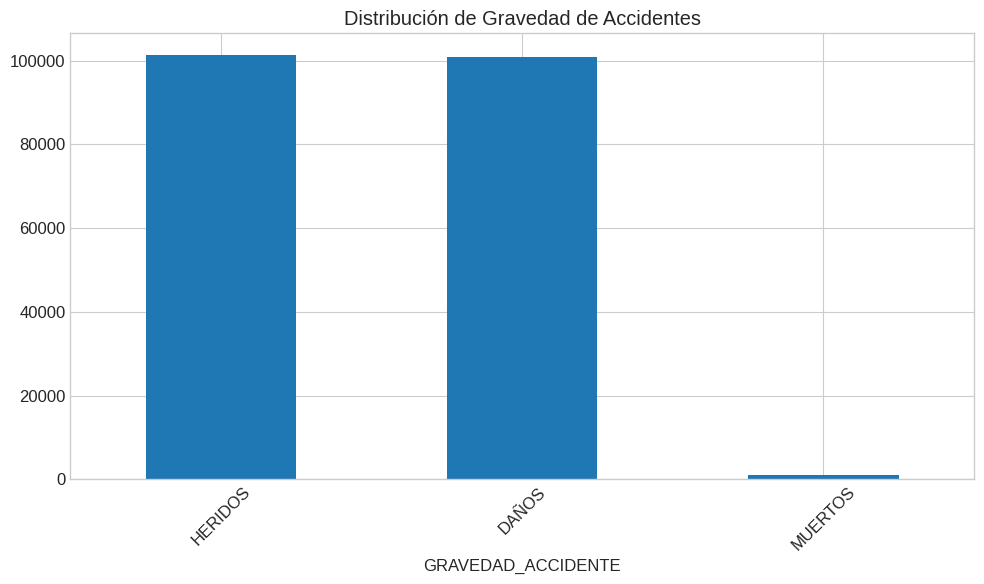

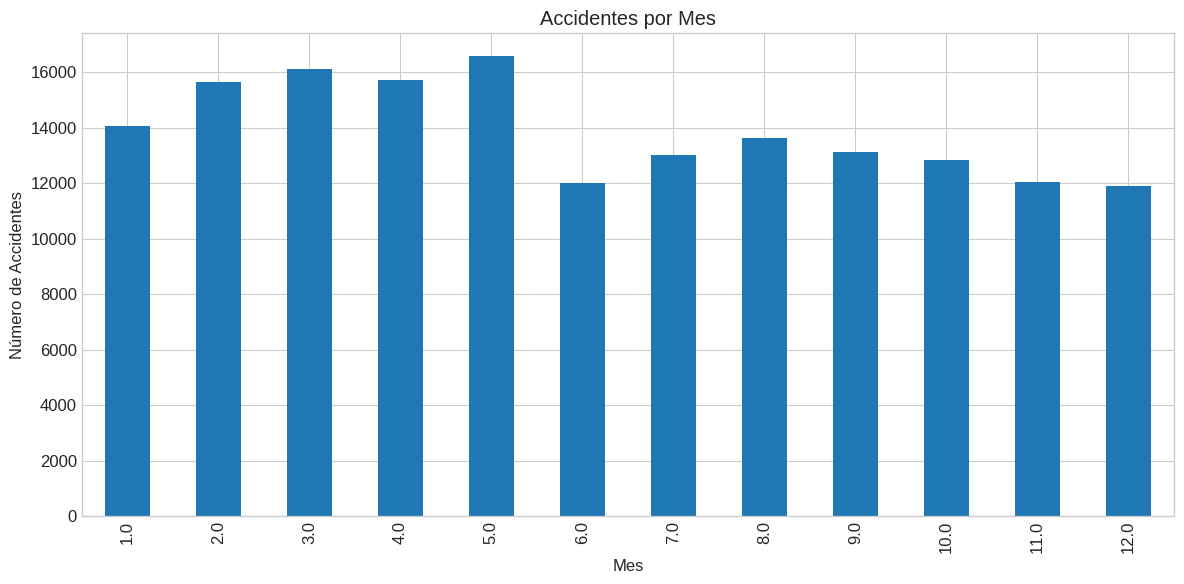


3. MACHINE LEARNING
Usando variable objetivo: GRAVEDAD_ACCIDENTE

⚙️ PREPARANDO DATOS PARA ML (Variable objetivo: GRAVEDAD_ACCIDENTE)...
Características numéricas (4): ['COD_MUNICIPIO', 'MES', 'DIA_SEMANA_NUM', 'AÑO']
Características categóricas (7): ['MUNICIPIO', 'DIA_SEMANA', 'CLASE', 'DIRECCIÓN', 'BARRIO', 'COMUNA', 'DISEÑO']
Variable objetivo codificada. Clases: ['DAÑOS', 'HERIDOS', 'MUERTOS']
Conjunto de entrenamiento: 162748 muestras
Conjunto de prueba: 40687 muestras

 ENTRENANDO Y COMPARANDO MODELOS...

VALIDACIÓN CRUZADA (3 folds para mayor velocidad):


In [ ]:
# Ejecutar el análisis
if __name__ == "__main__":
    main()